# Conditional GAN (cGAN)

Our goal is to create a cGAN to color black and white images. For this, we will use the ImageNet database.

## Data

FORWARD

> 1. Pil to array  
> 2. / 255  
> 3. rgb to lab  
> 4. ToTensor  
> 5. Normalize   

REVERSE

> 1. Unormalize   
> 2. Tensor to array  
> 3. lab to rgb  
> 4. * 255  
> 5. Return array






In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

from PIL import Image
from skimage import color
import pickle as pkl
import os
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

In [56]:
class colorCIFAR10(datasets.CIFAR10):

    def __init__(self, 
                 data_augmentation=False, normalization=True,
                 root='./data', train=True, download=True):
        print("Initializing colorCIFAR10...")

        super().__init__(root, train, download)

        # Compute mean std needed for normalization
        if normalization:
            print("Compute mean and std value for normalization...")
            mean, std = self.__compute_mean_std_for_normalization(transform=transforms.ToTensor())
            self.__mean_std_normalization = (mean, std)
            print(self.__mean_std_normalization)
            print("Compute done.")
        else:
            self.__mean_std_normalization = None

        # Must not be used --> always set to None for this task
        self.transform = None
        self.target_transform = None
        
        print("Init done.\n") 

    @property
    def get_mean_std_normalization(self):
        return (self.__mean_std_normalization[0], self.__mean_std_normalization[1])

    def __compute_mean_std_for_normalization(self, transform=transforms.ToTensor()):
        """
            Function used to determinate the mean and std of tensors after 
            transforms have been applied (scaling, rgb2lab and ToTensor)
            in order to apply the Normalization transform
        """
        scaled_data = self.data / 255
        images_tens = []
        for image in scaled_data:
            # rgb to lab -> [0, 100], [-128, 127], [-128, 127]
            image = color.rgb2lab(image)
            # apply transform
            image = transform(image).float()
            images_tens.append(image)
        images_tens = torch.stack(images_tens)
        
        mean = torch.mean(images_tens, dim=(0,2,3))
        std  = torch.std(images_tens, dim=(0,2,3))

        return [mean[i].item() for i in range(3)], [std[i].item() for i in range(3)]


    def __getitem__(self, index):

        # image is numpy array
        image, _ = super().__getitem__(index)

        # scaling to [0,1]
        image = np.array(image) / 255

        # convert rgb to lab -> [0, 100], [-128, 127], [-128, 127]
        image = color.rgb2lab(image)

        # ToTensor without scaling
        image = transforms.ToTensor()(image).float()

        # Normalization
        if self.__mean_std_normalization is not None:
            image = transforms.Normalize(self.__mean_std_normalization[0], self.__mean_std_normalization[1])(image)
        else:
            print("No normalization")

        # Layout of the object
        L  = image[0,:,:]
        ab = image[1:3,:,:] 
        
        return {'L' : L, 'ab' : ab}


def reverse_transforms_rgb2lab(image, mean, std):
    """
        input:  image tensor of shape (batch_size, channels, height, width)
        output: numpy array of shape (height, width, channels, batch_size)
        Reverse the transforms applied and convert lab to rgb.
    """
    #L  = image['L']
    #ab = image['ab']

    L  = image[:,0,:,:].unsqueeze(1)
    ab = image[:,1:3,:,:] 

    # rescale to [0,100], [-128,127], [-128,127]
    L = (L * std[0]) + mean[0]
    ab[:,0,:,:] = (ab[:,0,:,:] * std[1]) + mean[1]
    ab[:,1,:,:] = (ab[:,1,:,:] * std[2]) + mean[2]

    lab_image       = torch.concat([L, ab], dim=1)
    if lab_image.requires_grad:
        lab_array_image = lab_image.permute(2,3,1,0).detach().cpu().numpy()
    else:
        lab_array_image = lab_image.permute(2,3,1,0).cpu().numpy()

    rgb_array_images = np.zeros_like(lab_array_image)
    for img_idx in range(lab_array_image.shape[0]):
        rgb_array_images[:,:,:,img_idx] = color.lab2rgb(lab_array_image[:,:,:,img_idx]) * 255

    return np.uint(rgb_array_images)


def get_dataloader(dataset, **kwargs) -> DataLoader:
     
    if dataset is None:
        raise ValueError("Dataset object must not be None.")

    if 'batch_size' in kwargs:
            _batch_size = kwargs.get('batch_size')
    else:
        _batch_size = 32

    if 'shuffle' in kwargs:
        _shuffle = kwargs.get('shuffle')
    else:
        _shuffle = True

    return DataLoader(dataset, shuffle=_shuffle, batch_size=_batch_size)


## Model

For the purpose of pix2pix, the generator will follow an encoder-decoder architecture. The discriminator has to be adapted for a binary classification (Fake or Real).  
  

### Generator

In [5]:
import torch.nn.functional as functional

In [6]:
class Conv_x2(nn.Module):

    def __init__(self, in_channels, out_channels, dropout=False, dropout_val=0):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.dropout      = dropout
        self.dropout_val  = dropout_val

        self.conv_x2 = nn.Sequential()
        prev_channels = self.in_channels

        for i in range(2):

            self.conv_x2.append(nn.Conv2d(prev_channels, self.out_channels, kernel_size=3, padding=1))
            self.conv_x2.append(nn.BatchNorm2d(self.out_channels))

            if dropout:
                self.conv_x2.append(nn.Dropout2d(p=dropout_val, inplace=True))

            self.conv_x2.append(nn.LeakyReLU(inplace=True))
            prev_channels = self.out_channels

    def forward(self, x):
        return self.conv_x2(x)

In [7]:
class Block_down_unet(nn.Module):

    def __init__(self, in_channels, out_channels, dropout=False, dropout_val=0):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.dropout      = dropout
        self.dropout_val  = dropout_val

        self.block = nn.Sequential (
            nn.AvgPool2d(kernel_size=2),
            Conv_x2(self.in_channels, self.out_channels, self.dropout, self.dropout_val)
        )

    def forward(self, x):
        return self.block(x)

In [8]:
class Block_up_unet(nn.Module):

    def __init__(self, in_channels, out_channels, dropout=False, dropout_val=0):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.dropout      = dropout
        self.dropout_val  = dropout_val
        
        self.upsampling   = nn.ConvTranspose2d(self.in_channels, out_channels = self.in_channels // 2, kernel_size=2, stride=2)
        self.conv_x2      = Conv_x2(self.in_channels, self.out_channels, self.dropout, self.dropout_val)

    def forward(self, x, concat_tensor):

        x = self.upsampling(x)

        diffH = concat_tensor.size()[2] - x.size()[2]
        diffW = concat_tensor.size()[3] - x.size()[3]

        x = functional.pad(x, [diffW // 2, diffW - diffW // 2,
                                diffH // 2, diffH - diffH // 2])

        x_res = torch.cat([concat_tensor, x], dim=1)

        return self.conv_x2(x_res)
        

In [9]:
class UNet(nn.Module):

    def __init__(self, n_in_channels, n_out_channels, depth, **kwargs):
        super().__init__()

        self.n_in_channels  = n_in_channels
        self.n_out_channels = n_out_channels
        self.mid_channels_list = [32 * 2**i for i in range(depth + 1)]
        self.down_part = nn.ModuleList()
        self.up_part   = nn.ModuleList()

        if 'dropout' in kwargs:
            self.dropout = kwargs.get('dropout')
        else:
            self.dropout = False
        if 'dropout_val' in kwargs:
            self.dropout_val = kwargs.get('dropout_val')
        else:
            self.dropout_val = 0.5

        self.input_layer  = Conv_x2(self.n_in_channels, self.mid_channels_list[0])
        self.output_layer = Conv_x2(self.mid_channels_list[0], self.n_out_channels) 

        # Encoder path
        for i in range(depth):
            self.down_part.append(
                Block_down_unet(self.mid_channels_list[i], self.mid_channels_list[i + 1])
            )
        # Up path
        for i in reversed(range(depth)):
            self.up_part.append(
                Block_up_unet(self.mid_channels_list[i + 1], self.mid_channels_list[i], dropout=self.dropout, dropout_val=self.dropout_val)
            )

    def forward(self, x):

        down_block_outputs = []

        # First layer
        x = self.input_layer(x)
        down_block_outputs.append(x)
        
        # Encoder path
        for i, down_layer in enumerate(self.down_part):
            x = down_layer(x)
            down_block_outputs.append(x)            
        
        # Decoder path with res path
        for i, up_layer in enumerate(self.up_part, start=1):
            x = up_layer(x, down_block_outputs[-i - 1])
        

        return self.output_layer(x)


### Discriminator

In [11]:
class PatchDiscriminator(nn.Module):

    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()

        model = [self.get_layers(input_c, num_filters, norm=False)]
        # the 'if' statement is taking care of not using stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] 
        # Make sure to not use normalization or activation for the last layer of the model
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] 

        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]         
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
                                                                                             
    def forward(self, x):
        return self.model(x)

## Trainer

The adversarial aspect of the training makes it split into 2 phases.   
The first focuses on the training of the discriminator without the generator. We feed it with two batchs: a batch of real examples sampled from the training set and a batch of fakes examples produced by the generator. The labels are set to 0 for fake images and 1 for real ones. 
We'll simply use the binary cross-entropy loss that seems natural this case. As we only train the discriminator, the generator's weights must be freeze.  
During the second phase, we train the generator without training the discriminator. This means that we'll have to freeze the discriminator's weights. Moreover, we'll produce fake images but set the target to 1 (real) and use again the binary cross-entropy loss.
In order to help the neural net to learn the colors we aim at, we add a regularization term. We choose the L1 loss to avoid a blur effect.

Thanks to the Pytorch framework, in order to compute and backpropagate, we can use 2 optimizers that are able to optimize layers' params. However, the compute of the backpropagation needs to freeze layers that we don't want to update.

In [13]:
import pickle as pkl

In [14]:
class cGANTrainer:

    def __init__(self, device):
        self.device = device


    def D_train_step(self, dataloader,
               discriminator, generator,
               optimizer_D, criterion):
        """
            Discriminator training step.
            During this phase generator's layers must be frozen.
            We feed first a batch of fake images and then a real ones since it seems according to scientific papers that it 
            is a best way to do that.
        """
        # running loss on fake preds, running loss on real preds
        running_loss = [0.0, 0.0]

        # freeze the generator's layers
        for param in generator.parameters():
            if param.requires_grad:
                param.requires_grad = False

        # train the discriminator layers
        for param in discriminator.parameters():
            if not param.requires_grad:
                param.requires_grad = True

        for image in dataloader:
            # setting discriminator's gradients to 0 (could have use discriminator.zero_grad() too)
            optimizer_D.zero_grad()

            L_component = image['L'].unsqueeze(1).to(self.device)

            # fake images 
            fake_ab_component = generator(L_component)
            fake_imgs         = torch.cat([L_component, fake_ab_component], dim=1)
            preds_on_fake = discriminator(fake_imgs)
            loss_on_fake  = criterion(torch.zeros_like(preds_on_fake).to(self.device), preds_on_fake)

            running_loss[0] += loss_on_fake.item()

            # real images
            real_imgs     = torch.cat([L_component, image['ab'].to(self.device)], dim=1)
            preds_on_real = discriminator(real_imgs)
            loss_on_real     = criterion(torch.ones_like(preds_on_real), preds_on_real)
            running_loss[1] += loss_on_real.item()

            # backprop and update
            total_loss = loss_on_fake + loss_on_real
            total_loss.backward()
            optimizer_D.step()

            #print(running_loss)

        for i in range(len(running_loss)):
            running_loss[i] = running_loss[i] / len(dataloader)
        #print(running_loss)

        return running_loss

    
    def G_train_step(self, dataloader,
                     discriminator, generator,
                     optimizer_G, criterion,
                     reg_loss, reg_lambda):
        """
            Generator training step.
            During this phase discriminator's layers must be frozen.
            We generate a fake batch and set the value at 1 because we aim at making the discriminator recognizing the batch as True.
            Morever, we add some regularization in order to penalize the difference of colours.
            Return the mean of losses on generated data
        """
        # running loss on generated images and colors diff
        running_loss = [0.0, 0.0]

        # freeze the discriminator's layers
        for param in discriminator.parameters():
            if param.requires_grad:
                param.requires_grad = False

        # train the generator's layers
        for param in generator.parameters():
            if not param.requires_grad:
                param.requires_grad = True

        for image in dataloader:
            # setting generator's gradients to 0 (could have use generator.zero_grad() too)
            optimizer_G.zero_grad()

            L_component            = image['L'].unsqueeze(1).to(self.device)
            generated_ab_component = generator(L_component)
            generated_imgs         = torch.cat([L_component, generated_ab_component], dim=1)

            # concurential loss
            preds_on_generated = discriminator(generated_imgs)
            loss_on_generated  = criterion(torch.ones_like(preds_on_generated).to(self.device), preds_on_generated)

            # regularization loss 
            real_ab_component = image['ab'].to(self.device)
            reg_term = reg_loss(generated_ab_component, real_ab_component)

            # compute the backprop and update
            total_loss = loss_on_generated + reg_lambda * reg_term
            total_loss.backward()
            optimizer_G.step()

            # collect losses
            running_loss[0] += loss_on_generated.item()
            running_loss[1] += reg_term.item()
            #print(running_loss)

        for i in range(len(running_loss)):
            running_loss[i] = running_loss[i] / len(dataloader)
        #print(running_loss)

        return running_loss 

    
    def train(self, n_epochs, trainloader,
              discriminator, generator,
              optimizer_D, optimizer_G, criterion, 
              reg_loss, reg_lambda,
              file_path_save_discriminator, file_path_save_generator,
              results_file_path):
        """
            Main training entry point.
        """
        print("Starting training...\n")

        # sending to device
        if next(generator.parameters()).device != self.device:
            generator = generator.to(self.device)
        if next(discriminator.parameters()).device != self.device:
            discriminator = discriminator.to(self.device)
        print("The model will be running on", next(generator.parameters()).device, "device.\n")

        results = []

        for epoch in range(1, n_epochs+1):

            loss_D_on_epoch = self.D_train_step(trainloader,
                                                discriminator, generator,
                                                optimizer_D, criterion)

            loss_G_on_epoch = self.G_train_step(trainloader,
                                                discriminator, generator,
                                                optimizer_G, criterion,
                                                reg_loss, reg_lambda)
            

            print(f'Epoch: {epoch}, discriminator train loss: [{loss_D_on_epoch[0]:.4f}, {loss_D_on_epoch[1]:.4f}],',
                                    f'generator train loss: [{loss_G_on_epoch[0]:.4f}, {loss_G_on_epoch[1]:.4f}]')
            
            results.append((loss_D_on_epoch, loss_G_on_epoch))

        # Saving model
        print('Saving the models...\n')
        discriminator = discriminator.to('cpu')
        generator     = generator.to('cpu')
        self.save_model(discriminator, generator, 
                        file_path_save_discriminator, file_path_save_generator)

        # Saving the performances
        with open(results_file_path, 'wb') as f:
            pkl.dump(results, f) 

        print("Training finish.\n") 

        return discriminator, generator


    def save_model(self, 
                   discriminator, generator,
                   d_file_path, g_file_path):
        """
            Function to save models' parameters
        """
        torch.save(discriminator.state_dict(), d_file_path)
        torch.save(generator.state_dict(), g_file_path)

## Utils

In [16]:
def load_generator(file_path, gen_model):
    params = torch.load(file_path)
    gen_model.load_state_dict(params)

## Main

In [17]:
from torchmetrics import Dice

In [18]:
def main():

    # data
    trainset    = colorCIFAR10(data_augmentation=False, normalization=True)
    # By default: shuffle=True, batch_size=32
    trainloader = get_dataloader(trainset)

    # models
    n_in_channels  = 1
    n_out_channels = 2
    depth = 3
    generator = UNet(n_in_channels, n_out_channels, depth)

    input_c = 3
    discriminator = PatchDiscriminator(input_c, num_filters=64, n_down=2)

    # training
    trainer     = cGANTrainer(device='cuda:0')
    d_lr        = 1e-4
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=d_lr)
    criterion   = torch.nn.BCEWithLogitsLoss()

    n_epochs = 10
    g_lr = 1e-4
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=g_lr)

    reg_loss = nn.L1Loss(reduction='sum')
    reg_lambda = 1.

    file_path_save_discriminator = "./saving/test_trained_discriminator.pth"
    file_path_save_generator     = "./saving/test_trained_generator.pth"
    results_file_path            = "./saving/test_results.pth"

    disc, gen = trainer.train(n_epochs, trainloader,
                            discriminator, generator,
                            optimizer_D, optimizer_G, criterion,
                            reg_loss, reg_lambda,
                            file_path_save_discriminator, file_path_save_generator,
                            results_file_path)
    
    return None
    
    

In [19]:
if __name__ == "__main__":
    
    main()

Initializing colorCIFAR10...
Compute mean and std value for normalization...
([50.853271484375, 0.3957647979259491, 5.725295066833496], [24.25847053527832, 10.15176773071289, 16.080947875976562])
Compute done.
Init done.

Starting training...

The model will be running on cuda:0 device.

Epoch: 1, discriminator train loss: [0.6931, -251.9730], generator train loss: [-563.1532, 45025.0500]
Epoch: 2, discriminator train loss: [0.6931, -1003.1774], generator train loss: [-1478.1304, 43993.2274]
Epoch: 3, discriminator train loss: [0.6931, -2072.0113], generator train loss: [-2689.1704, 43724.7645]
Epoch: 4, discriminator train loss: [0.6931, -3411.5519], generator train loss: [-4160.3001, 43487.4551]
Epoch: 5, discriminator train loss: [0.6931, -5001.7019], generator train loss: [-5875.8387, 43346.2647]
Epoch: 6, discriminator train loss: [0.6931, -6834.6274], generator train loss: [-7831.2263, 43157.5930]
Epoch: 7, discriminator train loss: [0.6931, -8906.6413], generator train loss: [-1

## Training analysis

In [60]:
def load_results_pkl(pkl_file_path):

    pkl_file = pkl.load(open(pkl_file_path, 'rb'))
    
    # list containing: (loss on fake, loss on real)
    d_loss = list()
    # list containing: (loss on generated, regularization term)
    g_loss = list()

    for d_train_loss, g_train_loss in pkl_file:
        d_loss.append(d_train_loss)
        g_loss.append(g_train_loss)

    return d_loss, g_loss

In [61]:
def plot_performances(d_loss, g_loss, save=True):

    fig, (ax0, ax1) = plt.subplots(1,2, sharex=True, figsize=(15,5))

    # get loss on fake and loss on real
    losses_on_fake = []
    losses_on_real = []
    for i in range(len(d_loss)):
        losses_on_fake.append(d_loss[i][0])
        losses_on_real.append(d_loss[i][1])

    print(losses_on_fake)
    ax0.plot([i+1 for i in range(len(d_loss))], losses_on_fake, label="loss on fake")
    ax0.plot([i+1 for i in range(len(d_loss))], losses_on_real, label="loss on ream")

    ax0.set_title("Evolution of Discriminator's losses")
    ax0.set_xticks([i+1 for i in range(len(d_loss)) if (i+1)%10 == 0])
    ax0.set_xlabel("Epoch")
    ax0.set_ylabel("Loss")
    ax0.grid()
    
    # get loss on generated and regularization loss term
    losses_on_generated = []
    regularization_term = []
    for i in range(len(d_loss)):
        losses_on_generated.append(g_loss[i][0])
        regularization_term.append(g_loss[i][1])

    ax1.set_title("Evolution of the Generator's losses")
    ax1.plot([i+1 for i in range(len(g_loss))], losses_on_generated, label="loss on generated")
    ax1.plot([i+1 for i in range(len(g_loss))], regularization_term, label="regularization term")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Accuracy 
    # ax2.plot([i+1 for i in range(len(g_loss))], g_loss)
    # ax2.set_xticks([i+1 for i in range(len(g_loss)) if (i+1)%10 == 0])
    # ax2.set_xlabel("Epoch index")
    # ax2.set_ylabel("Accuracy")
    # ax2.grid()

    suptitle = "Performances of the cGAN"
    fig.suptitle(suptitle)

    if save:
        plt.savefig(suptitle + ".pdf")

    plt.show()


[0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996, 0.6931471824645996]


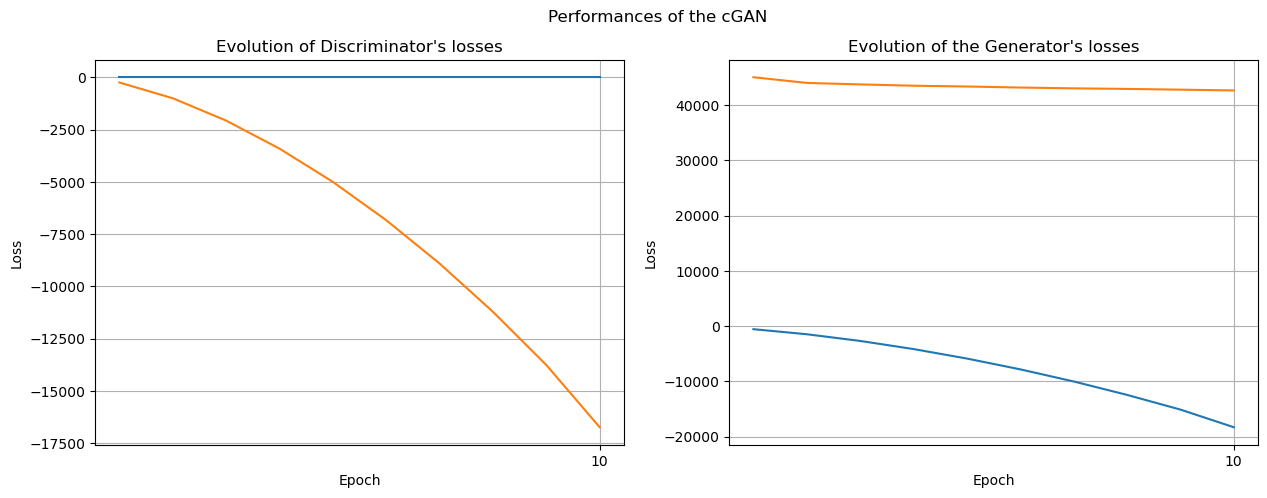

In [63]:
pkl_file_path  = "./saving/test_results.pth"
d_loss, g_loss = load_results_pkl(pkl_file_path)

plot_performances(d_loss, g_loss, save=True)

## Performances

Running the generator on the test dataset.

In [107]:
def plot_images_results(gen_model, 
                        dataloader, mean, std,
                        n_images_to_plot):

    fig = plt.figure(figsize=(15,15))
    fig.suptitle("Display few inferences of the generator trained with 10 epochs")

    for images in dataloader:  

        for i in range(0, 3 * n_images_to_plot, 3):

            # inference
            image_L_component = images['L'].unsqueeze(1)
            image_ab_component = images['ab']
            generated_ab_component = gen_model(image_L_component)
            
            # Black and white image
            ax1 = plt.subplot(7,3,i+1)      
            black_white_image = image_L_component.squeeze(1).detach().cpu().permute(1,2,0).numpy()
            ax1.imshow(black_white_image[:,:,i], cmap='gray')
            if i == 0:
                ax1.set_title("Input")

            # Ground truth image (convert to RGB + plot)
            ax2 = plt.subplot(7,3,i+2)
            real_image = torch.cat([image_L_component, image_ab_component], dim=1)
            real_image = reverse_transforms_rgb2lab(real_image, mean, std)
            ax2.imshow(real_image[:,:,:,i])
            if i == 0:
                ax2.set_title("Ground truth")

            # Generated image (convert to RGB + plot)
            ax3 = plt.subplot(7,3,i+3)
            colored_image = torch.cat([image_L_component, generated_ab_component], dim=1)
            generated_image = reverse_transforms_rgb2lab(colored_image, mean, std)
            ax3.imshow(generated_image[:,:,:,i])
            if i == 0:
                ax3.set_title("Generated image")
        
        break

    plt.show()

Initializing colorCIFAR10...
Compute mean and std value for normalization...
([51.16001510620117, 0.42790839076042175, 5.589690208435059], [24.1872501373291, 10.109152793884277, 16.114336013793945])
Compute done.
Init done.



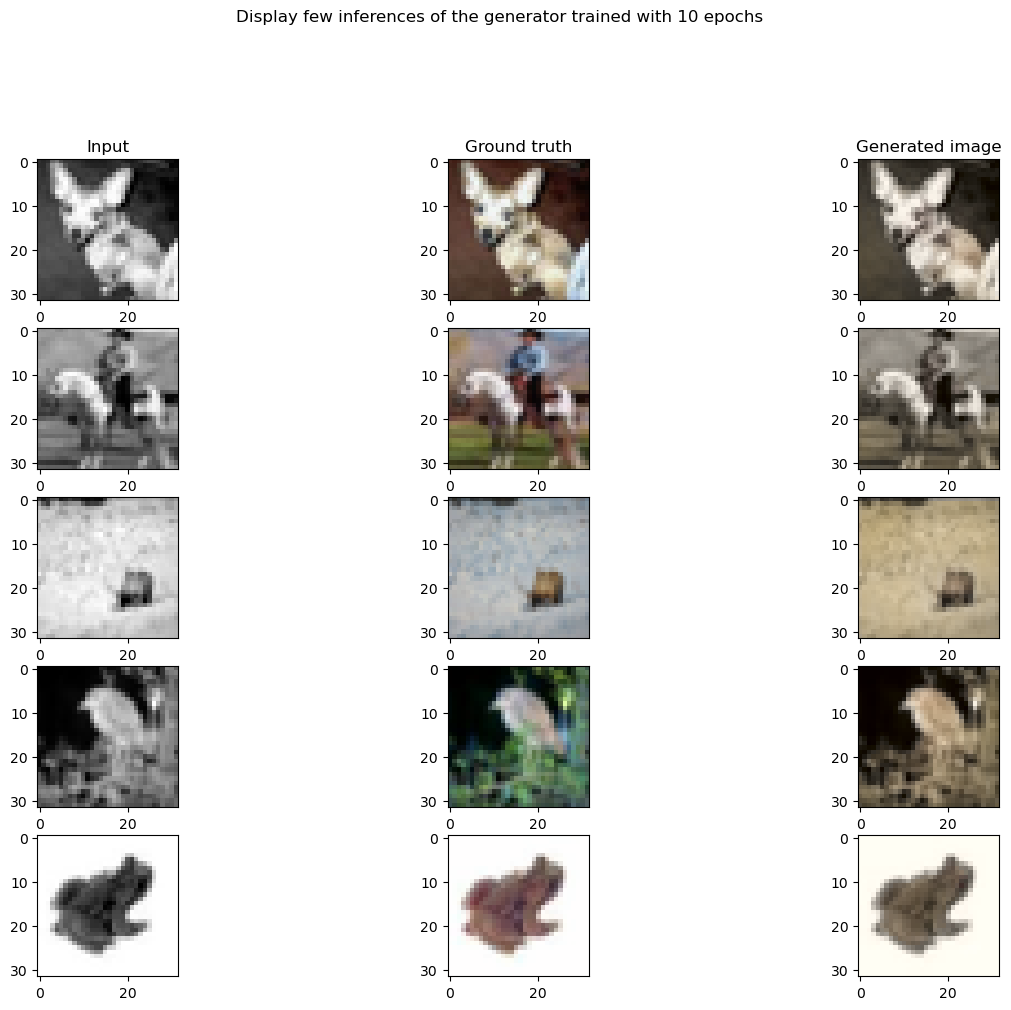

In [117]:
# test data
testset    = colorCIFAR10(data_augmentation=False, normalization=True, root='./data', train=False, download=True)
testloader = get_dataloader(testset)
mean = [51.16001510620117, 0.42790839076042175, 5.589690208435059]
std  = [24.1872501373291, 10.109152793884277, 16.114336013793945]

# load trained generator
n_in_channels  = 1
n_out_channels = 2
depth = 3

gen_model = UNet(n_in_channels, n_out_channels, depth)
file_path = "./saving/test_trained_generator.pth"
load_generator(file_path, gen_model)

n_images_to_plot = 5

plot_images_results(gen_model, 
                    testloader, mean, std,
                    n_images_to_plot)